# V1 프로젝트 - 탐색적 데이터 분석 (EDA)

이 주피터 노트북은 '중고차 가격 예측 프로젝트'의 V1 버전 데이터를 기반으로 한 탐색적 데이터 분석(EDA) 과정을 담고 있습니다.
데이터의 특징을 이해하고, 주요 피처(Feature)와 타겟(Target) 변수 간의 관계를 시각적으로 확인하며, 모델링에 필요한 인사이트를 도출하는 것이 목표입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

## 1. 데이터 로드 및 기본 정보 확인
V1 프로젝트에서 사용했던 `used_cars.csv` 데이터를 로드하고, 기본적인 정보를 확인합니다.

In [2]:
df = pd.read_csv('../data/used_cars.csv') # 데이터 폴더 경로에 맞춰 수정

print("데이터셋 상위 5행:\n", df.head())
print("\n데이터셋 정보:\n")
df.info()
print("\n데이터셋 기술 통계량:\n", df.describe())

데이터셋 상위 5행:
       brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Auto

## 2. 데이터 전처리 (V1 기준)
V1 프로젝트에서 수행했던 주요 전처리 과정을 재현합니다.
- `price`, `milage` 열 숫자 변환
- `engine` 열에서 `horsepower`, `engine_L`, `cylinders` 추출
- `model_year`를 이용한 `car_age` 생성
- 이상치 제거 (상위 5% 가격)

In [3]:
# 'price' 열: '$'와 ',' 제거 후 숫자(float)로 변환
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

# 'milage' 열: ' mi.'와 ',' 제거 후 숫자(int)로 변환
df['milage'] = df['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)

# 'horsepower' 열: 'engine' 열에서 마력(HP) 정보 추출 (정규표현식 사용)
df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)\s*HP').astype(float)

# 'engine_L' 열: 'L' 앞에 있는 숫자 추출
df['engine_L'] = df['engine'].str.extract(r'(\d+\.?\d*)\s*L').astype(float)

# 'cylinders' 열: 'Cylinder' 또는 'V' 앞에 있는 숫자 추출
df['cylinders'] = df['engine'].str.extract(r'(\d)\s*(?:Cylinder|V)').astype(float)

# 'car_age' 피처 생성
current_year = 2025 
df['car_age'] = current_year - df['model_year']

# 불필요한 열 삭제
df.drop(['engine', 'model_year'], axis=1, inplace=True)

# V1 이상치 처리 (가격 상위 5% 제거)
price_95th = df['price'].quantile(0.95)
df = df[df['price'] < price_95th]

print("\n전처리 후 데이터셋 정보:\n")
df.info()
print("\n전처리 후 데이터셋 상위 5행:\n", df.head())


전처리 후 데이터셋 정보:

<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, 0 to 4008
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         3808 non-null   object 
 1   model         3808 non-null   object 
 2   milage        3808 non-null   int64  
 3   fuel_type     3641 non-null   object 
 4   transmission  3808 non-null   object 
 5   ext_col       3808 non-null   object 
 6   int_col       3808 non-null   object 
 7   accident      3706 non-null   object 
 8   clean_title   3270 non-null   object 
 9   price         3808 non-null   float64
 10  horsepower    3085 non-null   float64
 11  engine_L      3597 non-null   float64
 12  cylinders     3409 non-null   float64
 13  car_age       3808 non-null   int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 446.2+ KB

전처리 후 데이터셋 상위 5행:
       brand                            model  milage      fuel_type  \
0      Ford  Utility Police Intercepto

## 2-1. 타겟 변수(price) 이상치 확인

본격적인 전처리에 앞서, 타겟 변수인 `price`의 분포를 박스 플롯(Box Plot)으로 시각화하여 이상치(Outlier)를 확인합니다. 이는 V1 모델링에서 가격 상위 5%를 제거했던 결정의 근거가 됩니다.

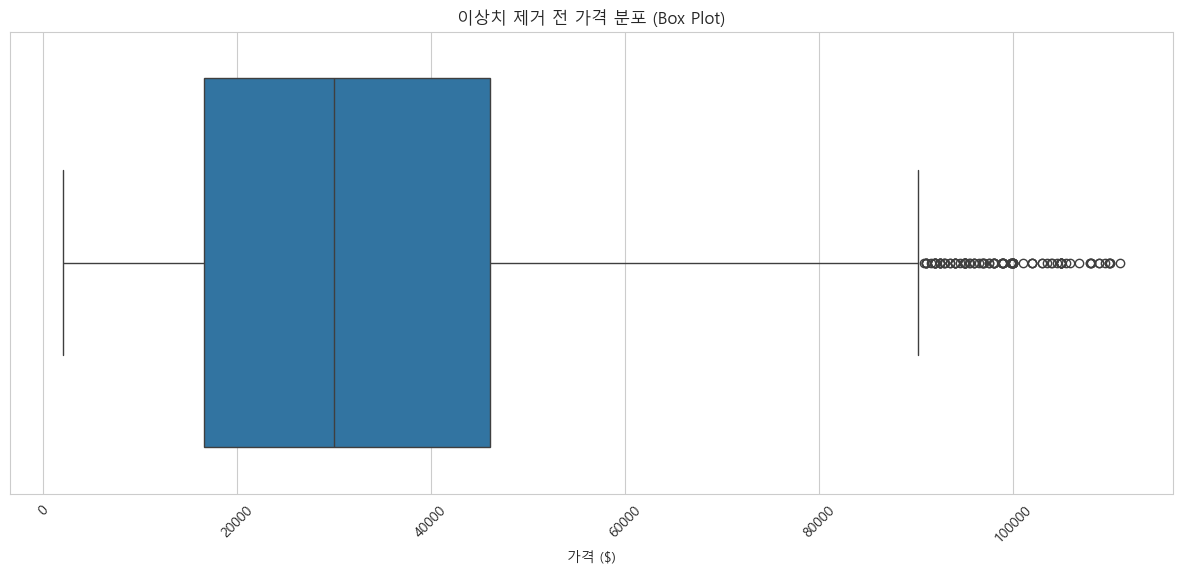

In [6]:
# V1의 이상치 제거 전 가격 데이터로 박스 플롯 생성
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['price'])
plt.title('이상치 제거 전 가격 분포 (Box Plot)')
plt.xlabel('가격 ($)')
plt.xticks(rotation=45)
plt.show()

## 3. 결측치 확인 (V1 기준)
V1에서는 `dropna()`로 결측치를 처리했습니다. EDA 단계에서는 어떤 열에 결측치가 얼마나 있는지 확인합니다.

In [4]:
print("\n결측치 개수:\n", df.isnull().sum())
print("\n결측치 비율 (%):\n", df.isnull().sum() / len(df) * 100)


결측치 개수:
 brand             0
model             0
milage            0
fuel_type       167
transmission      0
ext_col           0
int_col           0
accident        102
clean_title     538
price             0
horsepower      723
engine_L        211
cylinders       399
car_age           0
dtype: int64

결측치 비율 (%):
 brand            0.000000
model            0.000000
milage           0.000000
fuel_type        4.385504
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         2.678571
clean_title     14.128151
price            0.000000
horsepower      18.986345
engine_L         5.540966
cylinders       10.477941
car_age          0.000000
dtype: float64


## 4. 주요 변수 분포 탐색
타겟 변수인 `price`와 주요 수치형 피처들의 분포를 시각화하여 데이터의 특성을 파악합니다.

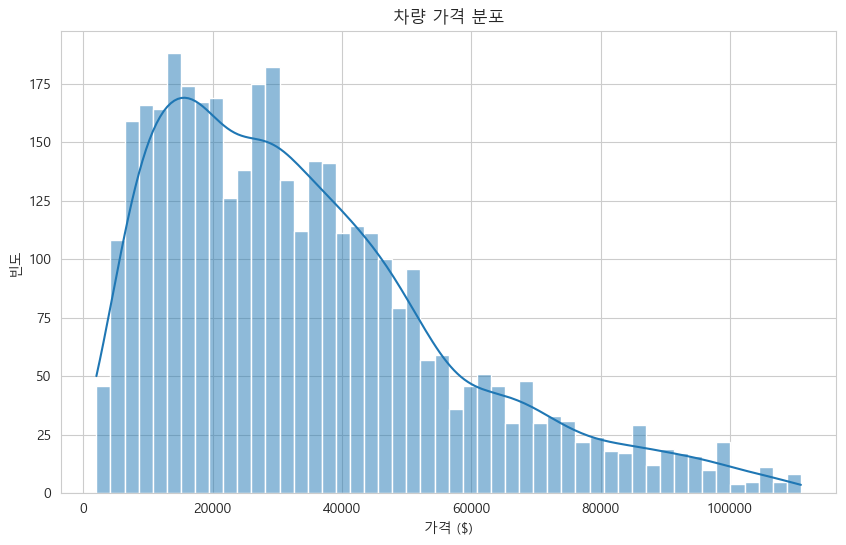

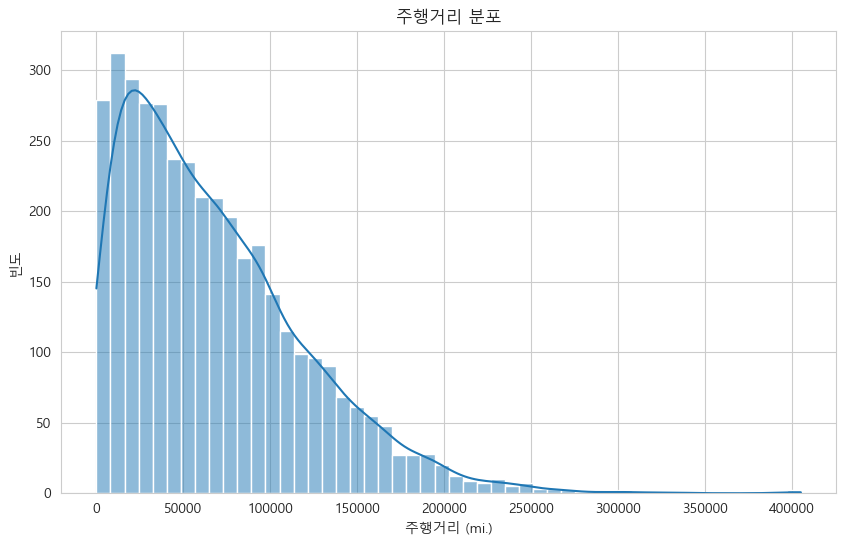

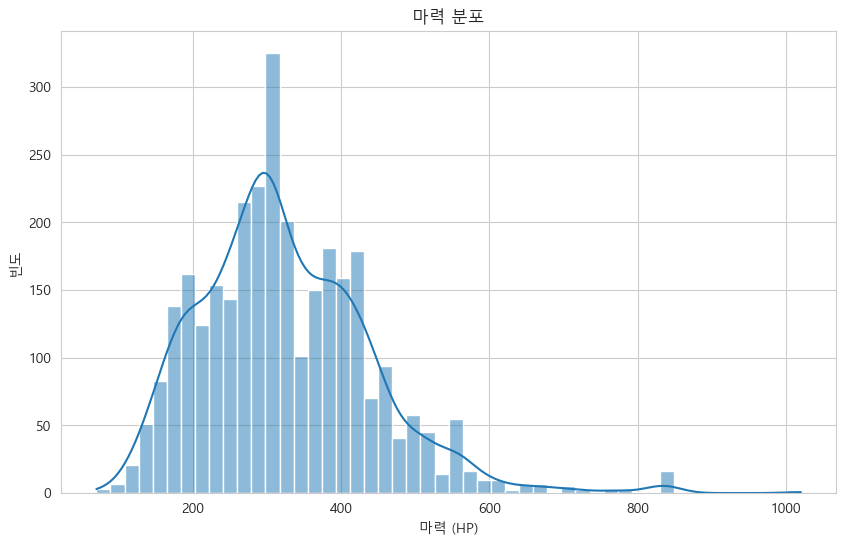

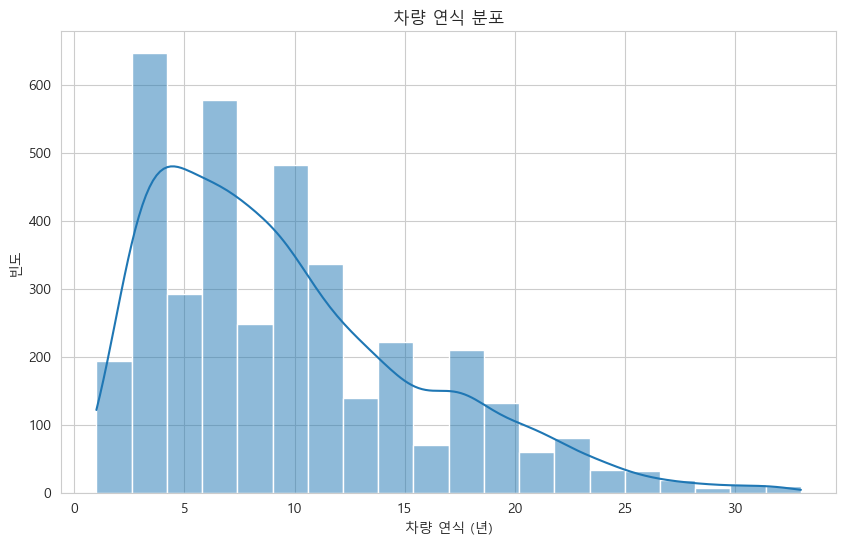

In [5]:
# price 분포
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('차량 가격 분포')
plt.xlabel('가격 ($)')
plt.ylabel('빈도')
plt.show()

# milage 분포
plt.figure(figsize=(10, 6))
sns.histplot(df['milage'], bins=50, kde=True)
plt.title('주행거리 분포')
plt.xlabel('주행거리 (mi.)')
plt.ylabel('빈도')
plt.show()

# horsepower 분포
plt.figure(figsize=(10, 6))
sns.histplot(df['horsepower'].dropna(), bins=50, kde=True) # 결측치 제외
plt.title('마력 분포')
plt.xlabel('마력 (HP)')
plt.ylabel('빈도')
plt.show()

# car_age 분포
plt.figure(figsize=(10, 6))
sns.histplot(df['car_age'], bins=20, kde=True)
plt.title('차량 연식 분포')
plt.xlabel('차량 연식 (년)')
plt.ylabel('빈도')
plt.show()

## 5. 피처 간 관계 탐색
주요 피처들과 `price` 간의 관계를 시각화하여 예측에 활용할 수 있는 패턴을 찾습니다.

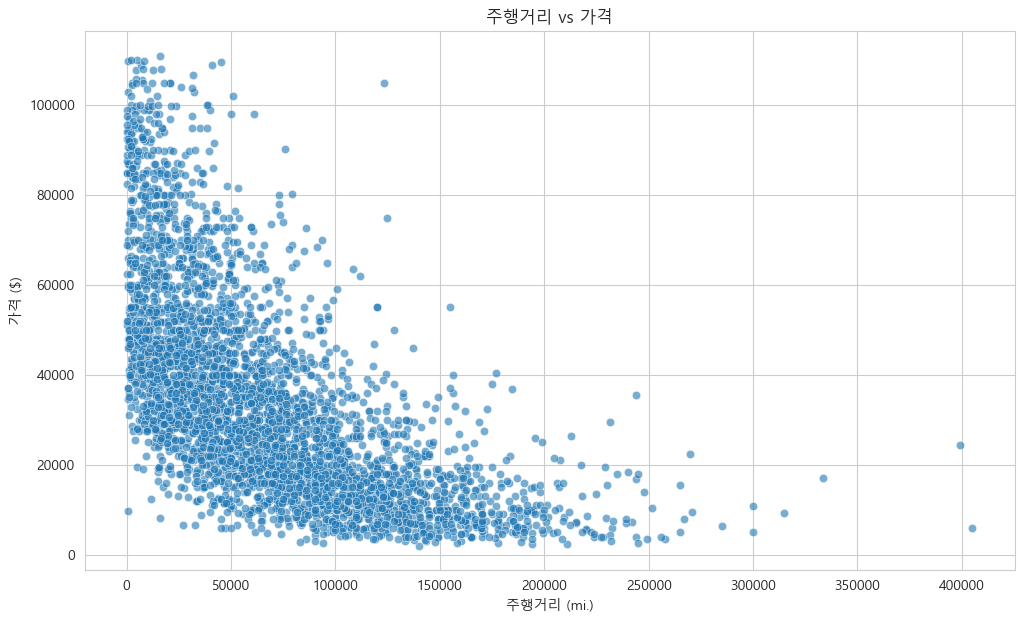

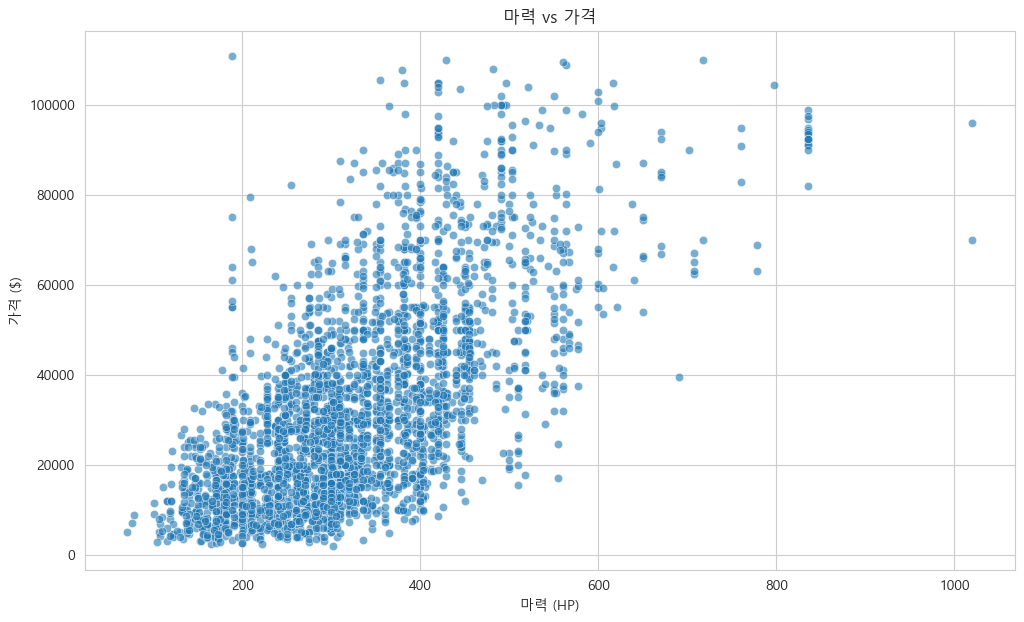

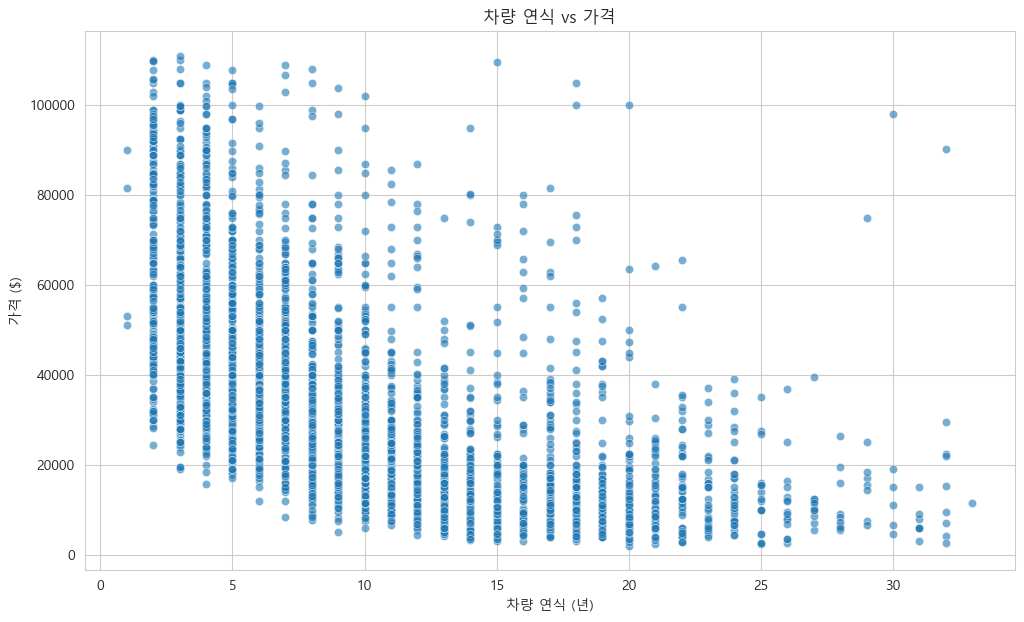

In [7]:
# 주행거리(milage)와 가격(price)의 관계
plt.figure(figsize=(12, 7))
sns.scatterplot(x='milage', y='price', data=df, alpha=0.6)
plt.title('주행거리 vs 가격')
plt.xlabel('주행거리 (mi.)')
plt.ylabel('가격 ($)')
plt.show()

# 마력(horsepower)과 가격(price)의 관계
plt.figure(figsize=(12, 7))
sns.scatterplot(x='horsepower', y='price', data=df.dropna(subset=['horsepower']), alpha=0.6)
plt.title('마력 vs 가격')
plt.xlabel('마력 (HP)')
plt.ylabel('가격 ($)')
plt.show()

# 차량 연식(car_age)과 가격(price)의 관계
plt.figure(figsize=(12, 7))
sns.scatterplot(x='car_age', y='price', data=df, alpha=0.6)
plt.title('차량 연식 vs 가격')
plt.xlabel('차량 연식 (년)')
plt.ylabel('가격 ($)')
plt.show()

## 6. 범주형 변수 분석
`brand`, `fuel_type`, `transmission`, `accident` 등 범주형 변수들이 가격에 어떤 영향을 미치는지 살펴봅니다.

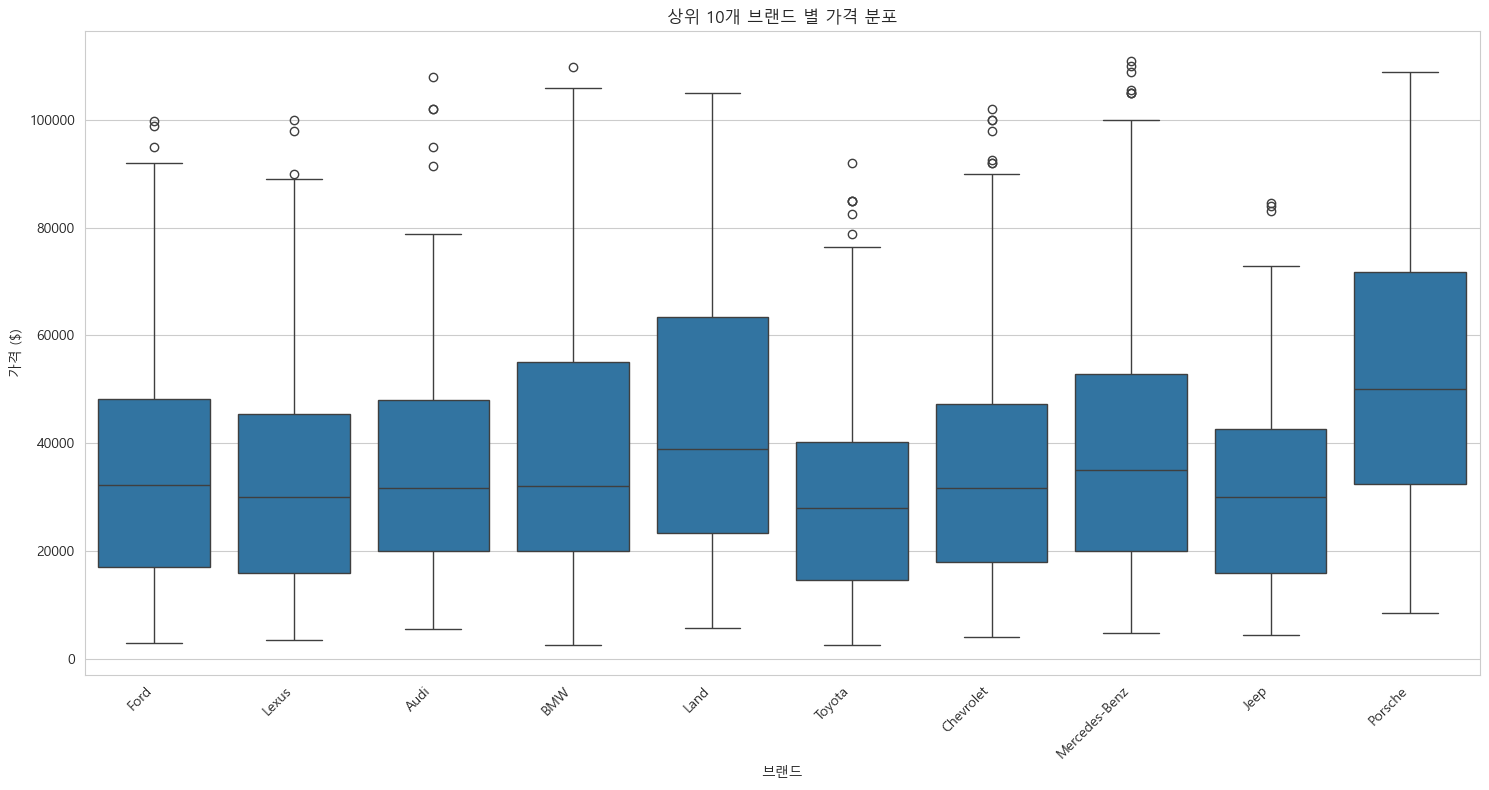

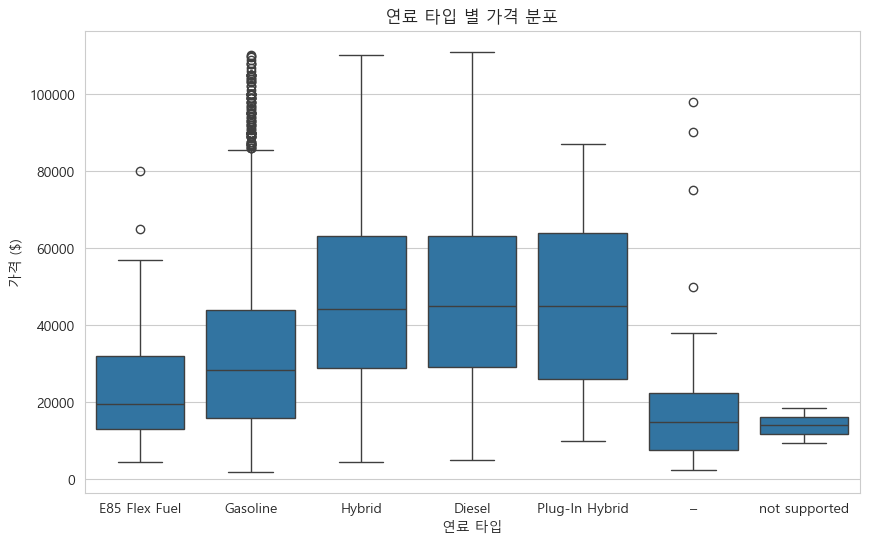

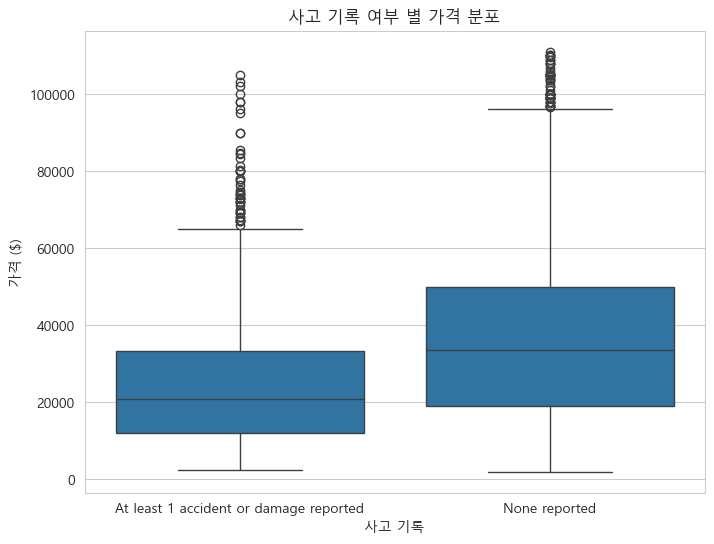

In [8]:
# brand 별 가격 분포
plt.figure(figsize=(15, 8))
# 상위 10개 브랜드만 선택 (너무 많으면 그래프가 복잡해짐)
top_brands = df['brand'].value_counts().nlargest(10).index
sns.boxplot(x='brand', y='price', data=df[df['brand'].isin(top_brands)])
plt.title('상위 10개 브랜드 별 가격 분포')
plt.xlabel('브랜드')
plt.ylabel('가격 ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# fuel_type 별 가격 분포
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df)
plt.title('연료 타입 별 가격 분포')
plt.xlabel('연료 타입')
plt.ylabel('가격 ($)')
plt.show()

# accident 여부 별 가격 분포
plt.figure(figsize=(8, 6))
sns.boxplot(x='accident', y='price', data=df)
plt.title('사고 기록 여부 별 가격 분포')
plt.xlabel('사고 기록')
plt.ylabel('가격 ($)')
plt.show()

## 7. 상관관계 분석
수치형 변수들 간의 상관관계를 히트맵으로 시각화하여 강한 상관관계를 가진 피처들을 식별합니다.

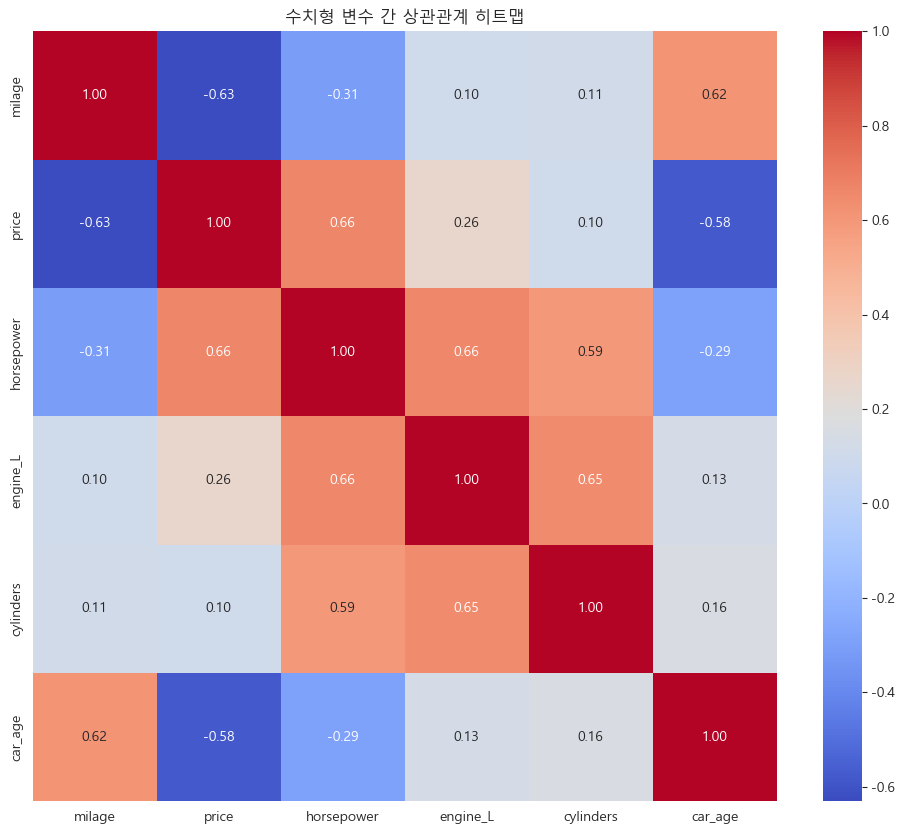

In [9]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('수치형 변수 간 상관관계 히트맵')
plt.show()